In [ ]:
# Clear unnecessary output
from IPython.display import clear_output

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install packages
!pip3 install hyperas
!pip3 install hyperopt
clear_output()

In [ ]:
# Imports
from tensorflow import keras
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
import numpy as np
import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

# Hyperparameter optimization

In [ ]:
# Create log file and initialize header
with open('hyperas-cifar10-log.csv', 'w') as csv_file:
  csv_file.write('n_layer1' + ';')
  csv_file.write('n_kernel1' + ';')
  csv_file.write('n_layer2' + ';')
  csv_file.write('n_kernel2' + ';')
  csv_file.write('n_pool1' + ';')
  csv_file.write('dropout_1' + ';')
  csv_file.write('dropout_2' + ';')
  csv_file.write('dense1' + ';')
  csv_file.write('dense2' + ';')
  csv_file.write('act' + ';')
  csv_file.write('optim' + ';')
  csv_file.write('n_batch' + ';')
  csv_file.write('best_val_acc' + '\n')

In [ ]:
def data():
    '''
        Loads the CIFAR-10 dataset. After that the split dataset is
        preprocessed.
    '''

    # Number of classes in CIFAR-10
    num_classes = 10

    # Load dataset
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # Create One-Hot encoded version of the y datasets
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    # Convert to float32
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    # Normalization
    X_train /= 255
    X_test /= 255
    return X_train, y_train, X_test, y_test

In [ ]:
def create_model(X_train, y_train, X_test, y_test):
    
    from keras.layers import Layer
    from keras import backend as K
    import gc

    # Hyperparameter definitions
    n_layer1 = {{choice([8, 14, 20, 26, 32, 38])}}
    n_kernel1 = {{choice([(3,3), (4,4), (5,5)])}}
    n_layer2 = {{choice([50, 54, 58, 62, 64, 68])}}
    n_kernel2 = {{choice([(3,3), (4,4)])}}
    n_pool1 = {{choice([(2,2), (3,3)])}}
    dropout_1 = {{uniform(0.1, 0.3)}}
    dropout_2 = {{uniform(0.3, 0.5)}}
    dense1 = {{choice([100, 130, 160, 180, 200])}}
    dense2 = {{choice([60, 80, 100])}}
    act = {{choice(['relu', 'leakyrelu'])}}
    optim = {{choice(['rmsprop',  'sgd'])}}
    n_batch = {{choice([8, 16, 24, 32])}}
    print('Hyperparameters: ', 
          {
            'n_layer1': n_layer1, 
            'n_kernel1': n_kernel1, 
            'n_layer2': n_layer2,
            'n_kernel2': n_kernel2, 
            'n_pool1': n_pool1,
            'dropout_1': dropout_1,
            'dropout_2': dropout_2, 
            'dense1': dense1, 
            'dense2': dense2,  
            'activation': act, 
            'optimizer': optim, 
            'batch_size': n_batch
           })
    
    # Choose activation function based on the string parameter
    if act == 'relu':
        activation = keras.layers.ReLU()
    elif act == 'leakyrelu':
        activation = keras.layers.LeakyReLU()
    
    # EarlyStopping callback
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, verbose=0)]
        
    # Model definition
    input = keras.layers.Input((32,32,3))

    X = keras.layers.Conv2D(n_layer1, n_kernel1) (input)
    X = keras.layers.BatchNormalization() (X)
    X = keras.layers.Activation(activation) (X)
    X = keras.layers.Dropout(dropout_1) (X)
    X = keras.layers.Conv2D(n_layer2, n_kernel2) (X)
    X = keras.layers.BatchNormalization() (X)
    X = keras.layers.Activation(activation) (X)
    X = keras.layers.AveragePooling2D(n_pool1) (X)
    X = keras.layers.Dropout(dropout_2) (X)

    X = keras.layers.Flatten() (X)
    X = keras.layers.Dense(dense1) (X)
    X = keras.layers.BatchNormalization() (X)
    X = keras.layers.Activation(activation) (X)
    X = keras.layers.Dropout(dropout_1) (X)
    X = keras.layers.Dense(dense2) (X)
    X = keras.layers.BatchNormalization() (X)
    X = keras.layers.Activation(activation) (X)
    X = keras.layers.Dropout(dropout_2) (X)
    output = Dense(10, activation='softmax') (X)
    model = keras.Model(inputs=input, outputs=output)

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, verbose=0)]
    
    result = model.fit(X_train, y_train,
              batch_size=n_batch,
              epochs=15,
              verbose=2,
              validation_data=(X_test, y_test),
              callbacks=callbacks,
              shuffle=True)

    # Get the best accuracy of the current iteration
    best_val_acc = np.amax(result.history['val_accuracy']) 
    print('Best validation accuracy:', best_val_acc)
    
    # Save result and parameters to csv
    with open('hyperas-cifar10-log.csv', 'a') as csv_file:
      csv_file.write(str(n_layer1) + ';')
      csv_file.write(str(n_kernel1) + ';')
      csv_file.write(str(n_layer2) + ';')
      csv_file.write(str(n_kernel2) + ';')
      csv_file.write(str(n_pool1) + ';')
      csv_file.write(str(dropout_1) + ';')
      csv_file.write(str(dropout_2) + ';')
      csv_file.write(str(dense1) + ';')
      csv_file.write(str(dense2) + ';')
      csv_file.write(str(act) + ';')
      csv_file.write(str(optim) + ';')
      csv_file.write(str(n_batch) + ';')
      csv_file.write(str(best_val_acc) + '\n')

    # Clear memory
    K.clear_session()
    gc.collect()

    # Return negative accuracy
    return {'loss': -best_val_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
# Run model optimization
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=200,
                                          notebook_name='drive/MyDrive/Colab Notebooks/hyperopt_hw',
                                          trials=Trials())

# Automatically download the log file after the optimization is finished.
files.download('hyperas-cifar10-log.csv')

Streaming output truncated to the last 5000 lines.

Epoch 12/15
1563/1563 - 9s - loss: 0.6206 - accuracy: 0.7840 - val_loss: 0.7676 - val_accuracy: 0.7349

Epoch 13/15
1563/1563 - 9s - loss: 0.6009 - accuracy: 0.7915 - val_loss: 0.8304 - val_accuracy: 0.7178

Best validation accuracy:
0.7426000237464905
Hyperparameters: 
{'n_layer1': 20, 'n_kernel1': (4, 4), 'n_layer2': 50, 'n_kernel2': (3, 3), 'n_pool1': (3, 3), 'dropout_1': 0.14027651081233028, 'dropout_2': 0.4319129547728101, 'dense1': 130, 'dense2': 80, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 16}
Epoch 1/15
3125/3125 - 12s - loss: 1.6260 - accuracy: 0.4171 - val_loss: 1.3046 - val_accuracy: 0.5393

Epoch 2/15
3125/3125 - 12s - loss: 1.3220 - accuracy: 0.5339 - val_loss: 1.3800 - val_accuracy: 0.5344

Epoch 3/15
3125/3125 - 11s - loss: 1.2063 - accuracy: 0.5811 - val_loss: 1.3455 - val_accuracy: 0.5357

Epoch 4/15
3125/3125 - 11s - loss: 1.1305 - accuracy: 0.6095 - val_loss: 1.0586 - val_accuracy: 0.6296

Epoch 5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Describe best model
best_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 29, 29, 38)        1862      
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 29, 38)        152       
_________________________________________________________________
activation (Activation)      (None, 29, 29, 38)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 38)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 62)        21266     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 62)       

In [ ]:
# Model evaluation
x_train, y_train, x_test, y_test = data()
print("Evaluate best model:")
print(best_model.evaluate(x_test, y_test))
print("Hyperparameters of best model:")
print(best_run)

Evaluate best model:
313/313 [==============================] - 1s 3ms/step - loss: 0.9371 - accuracy: 0.6835
[0.9370560646057129, 0.6834999918937683]
Hyperparameters of best model:
{'act': 0, 'dense1': 3, 'dense2': 0, 'dropout_1': 0.11193590880425972, 'dropout_2': 0.4858131283884246, 'n_batch': 2, 'n_kernel1': 1, 'n_kernel2': 0, 'n_layer1': 5, 'n_layer2': 3, 'n_pool1': 1, 'optim': 0}


# Analysis of the hyperoptimization


In [ ]:
# Imports
from ast import literal_eval as make_tuple
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Load log file
hyperas_log = pd.read_csv('hyperas-cifar10-log.csv', delimiter=';')

In [ ]:
# Slice 10 records with the best validation accuracy
hyperas_top = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).head(10)
hyperas_top

,n_layer1,n_kernel1,n_layer2,n_kernel2,n_pool1,dropout_1,dropout_2,dense1,dense2,act,optim,n_batch,best_val_acc
42,38,"(4, 4)",62,"(3, 3)","(3, 3)",0.111936,0.485813,180,60,relu,rmsprop,24,0.7678
116,38,"(4, 4)",62,"(4, 4)","(3, 3)",0.148248,0.412815,180,60,relu,rmsprop,32,0.7676
176,38,"(4, 4)",68,"(3, 3)","(3, 3)",0.119040,0.352989,200,60,relu,rmsprop,32,0.7625
78,38,"(4, 4)",62,"(3, 3)","(3, 3)",0.142041,0.338043,200,60,relu,rmsprop,32,0.7625
150,38,"(4, 4)",68,"(3, 3)","(3, 3)",0.127043,0.399060,200,60,relu,rmsprop,32,0.7612
35,38,"(4, 4)",68,"(3, 3)","(3, 3)",0.147763,0.430004,200,60,relu,rmsprop,32,0.7612
130,38,"(4, 4)",58,"(4, 4)","(3, 3)",0.139724,0.362929,180,100,relu,rmsprop,24,0.7601
22,38,"(4, 4)",50,"(3, 3)","(3, 3)",0.108713,0.415270,130,80,relu,rmsprop,16,0.7581
146,38,"(4, 4)",68,"(3, 3)","(3, 3)",0.129315,0.424873,200,60,relu,rmsprop,32,0.7581
114,38,"(4, 4)",62,"(3, 3)","(3, 3)",0.111285,0.360966,200,60,relu,rmsprop,32,0.7563


In [ ]:
# Slice 10 records with the worst validation accuracy
hyperas_tail = hyperas_log.sort_values(by=['best_val_acc'], ascending=False).tail(10)
hyperas_tail

,n_layer1,n_kernel1,n_layer2,n_kernel2,n_pool1,dropout_1,dropout_2,dense1,dense2,act,optim,n_batch,best_val_acc
103,8,"(4, 4)",54,"(3, 3)","(3, 3)",0.112778,0.492974,180,60,leakyrelu,sgd,32,0.6333
177,14,"(5, 5)",64,"(3, 3)","(3, 3)",0.108774,0.327037,180,80,leakyrelu,rmsprop,16,0.6326
171,26,"(5, 5)",62,"(3, 3)","(3, 3)",0.196612,0.395985,180,80,leakyrelu,sgd,24,0.6314
40,14,"(4, 4)",54,"(3, 3)","(2, 2)",0.173414,0.402506,160,60,relu,rmsprop,32,0.6297
6,8,"(5, 5)",50,"(3, 3)","(3, 3)",0.298780,0.345676,180,100,relu,sgd,32,0.6278
3,38,"(5, 5)",68,"(4, 4)","(3, 3)",0.132050,0.323460,160,60,leakyrelu,sgd,32,0.6167
48,38,"(4, 4)",64,"(3, 3)","(2, 2)",0.188203,0.437999,180,60,leakyrelu,sgd,24,0.6146
55,8,"(4, 4)",68,"(4, 4)","(3, 3)",0.133819,0.456710,200,100,relu,sgd,8,0.5992
110,14,"(4, 4)",64,"(3, 3)","(2, 2)",0.137293,0.349614,200,60,relu,rmsprop,32,0.5831
19,32,"(5, 5)",50,"(4, 4)","(2, 2)",0.291723,0.464531,180,80,leakyrelu,sgd,16,0.5636


In [ ]:
# Define analysis parameters
parameters = ['n_layer1', 'n_layer2',  
              'n_kernel1', 'n_kernel2', 
              'dropout_1', 'dropout_2',
              'dense1', 'dense2', 
              'n_pool1', 'n_batch',
              'act', 'optim']

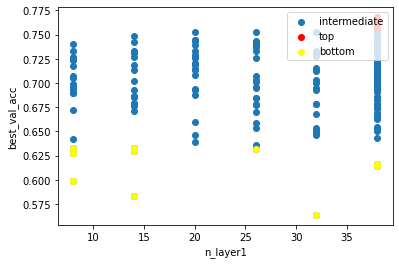

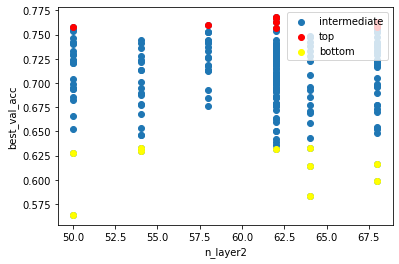

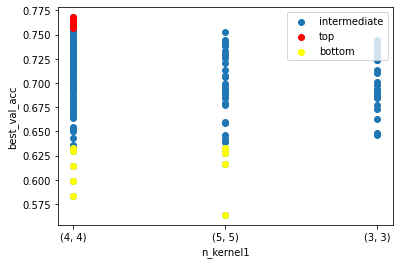

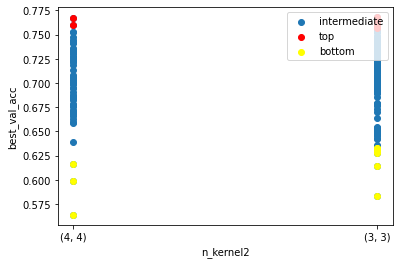

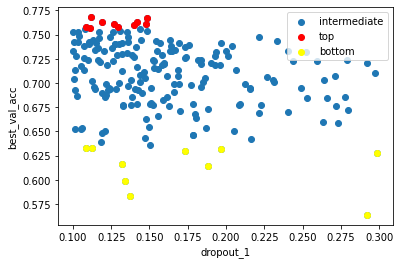

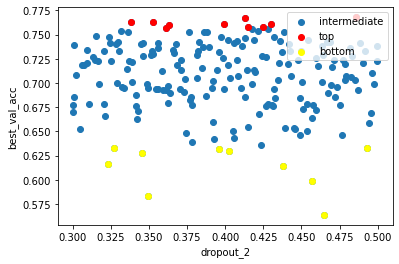

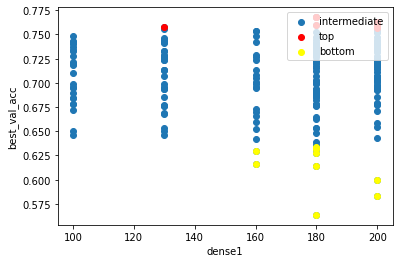

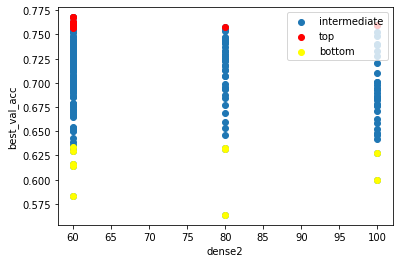

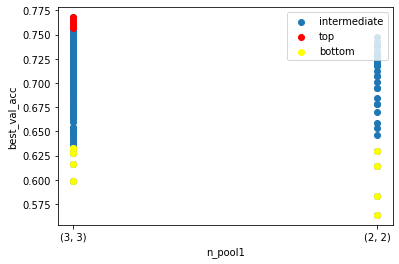

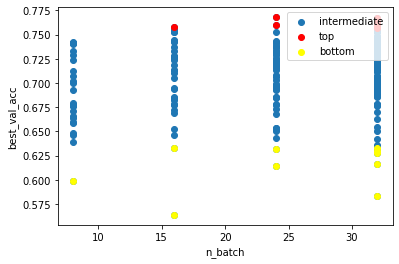

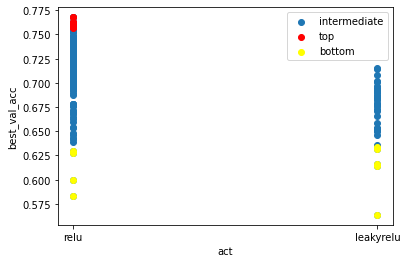

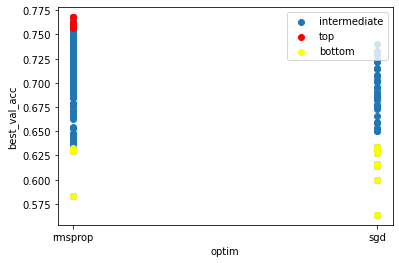

In [ ]:
# Plot results
# Top 10 record is red
# Bottom 10 record is yellow
# The others are blue 
for hyperparam in parameters:
  plt.scatter(hyperas_log[hyperparam], hyperas_log.best_val_acc, label='intermediate')
  plt.scatter(hyperas_top[hyperparam], hyperas_top.best_val_acc, color='red', label='top')
  plt.scatter(hyperas_tail[hyperparam], hyperas_tail.best_val_acc, color='yellow', label='bottom')
  plt.legend(loc='upper right')
  plt.xlabel(hyperparam)
  plt.ylabel('best_val_acc')
  plt.show()

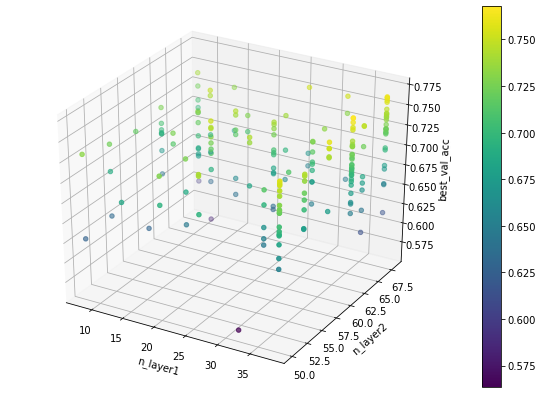

In [ ]:
# The accuracy's dependence on the channel count of the first and second convolutional layer combined.
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.n_layer1, hyperas_log.n_layer2, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('n_layer1')
ax.set_ylabel('n_layer2')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

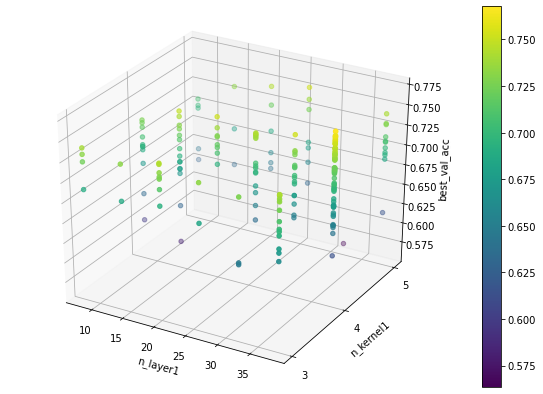

In [ ]:
# The accuracy's dependence on the channel count and kernel size of the first convolutional layer.
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.n_layer1, [make_tuple(x)[0] for x in hyperas_log.n_kernel1], hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_yticks([3,4,5])
ax.set_xlabel('n_layer1')
ax.set_ylabel('n_kernel1')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

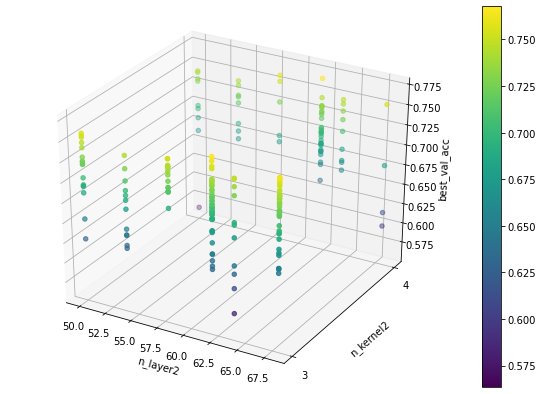

In [ ]:
# The accuracy's dependence on the channel count and kernel size of the second convolutional layer.
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.n_layer2, [make_tuple(x)[0] for x in hyperas_log.n_kernel2], hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_yticks([3,4,5])
ax.set_xlabel('n_layer2')
ax.set_ylabel('n_kernel2')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

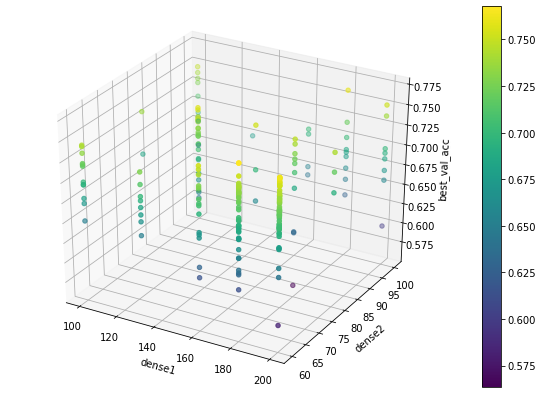

In [ ]:
# The accuracy's dependence on the unit size of the first and second dense layer combined.
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.dense1, hyperas_log.dense2, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('dense1')
ax.set_ylabel('dense2')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

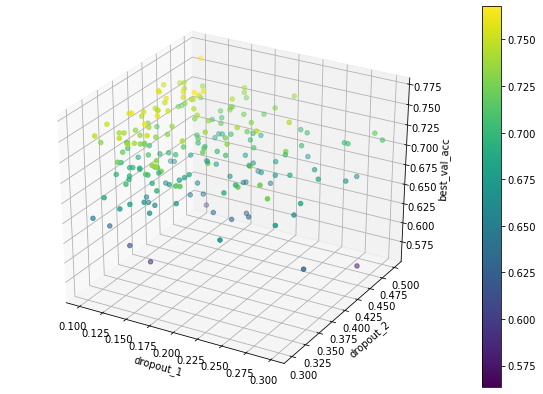

In [ ]:
# The accuracy's dependence on the ratio of the first and second dropout layer combined.
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.dropout_1, hyperas_log.dropout_2, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('dropout_1')
ax.set_ylabel('dropout_2')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

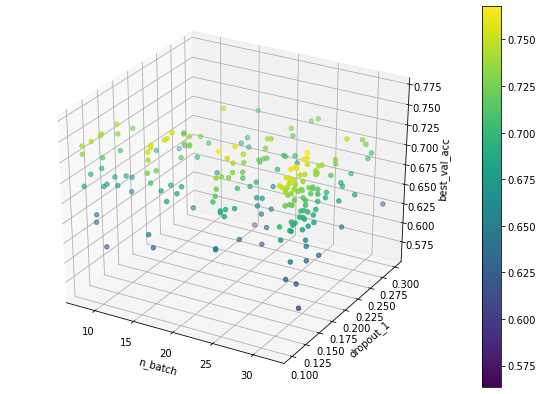

In [ ]:
# The accuracy's dependence on the batch size and the ratio of the first dropout layer combined.
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.n_batch, hyperas_log.dropout_1, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('n_batch')
ax.set_ylabel('dropout_1')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

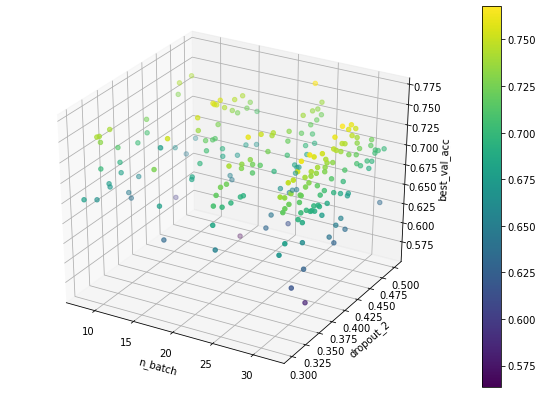

In [ ]:
# The accuracy's dependence on the batch size and the ratio of the second dropout layer combined.
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(hyperas_log.n_batch, hyperas_log.dropout_2, hyperas_log.best_val_acc, c=hyperas_log.best_val_acc)
ax.set_xlabel('n_batch')
ax.set_ylabel('dropout_2')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()